In [146]:
import os
import logging

from typing import List, Dict, Optional
from collections import namedtuple, Counter, defaultdict
from statistics import median

import lxml.etree as ET
import numpy as np
import requests
import requests_cache

from memoization import cached
from pandas import DataFrame
from sklearn.decomposition import PCA, FactorAnalysis as FA

import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import HTML, display

plt.style.use('seaborn')
requests_cache.install_cache('importance-segmentation.cache')

## Setup the lemmas that are interesting to search for

In [147]:
import glob
lemmas = []
for text in glob.glob("/home/thibault/dev/corpus-builder/output/*.xml"):
    xml = ET.parse(text)
    lemmas.extend([
        y[:y.find("(")]
        for x in xml.xpath("//w[@ana]/@lemma") 
        for y in x.split("|")
        if y
    ])
lemmas = sorted(list(set(lemmas)))


SERVER = "http://localhost:8888/blacklab-server/latin-corpus-index/hits"
GLOBAL_WINDOW = 10
MIN_FREQ = 10
COOC_MIN_FREQ = 10
COOC_USE_SUM = True
NORMALIZATION: str = "coeff-dice"
IGNORE_WORDS = ("sum1", "que", "habeo", "dico2", "facio", "possum1", "do", "uideo", "uolo3", "iam", "sic",
               "tamen", "tam", "puto", "res", "suus", "hic2")
TEXTS = ["urn:cts:latinLit:phi1294.phi002.perseus-lat2", "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1"]
TEXT_SPLITS = {
    "urn:cts:latinLit:phi1294.phi002.perseus-lat2": 2,  # Stop at the second element of citation
    "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1": 1
}
BAD_CACHE = defaultdict(Counter) # {textlist: {word: count}}
POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    "ADV", "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CONcoo", "CONsub", "INJ",
    "NOMcom", "NOMpro", 
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", "PROper", "PROpos", "PROpos", "PROref", "PROrel", "PUNC", 
    "VER", "VERaux", "FOR"
]
IGNORE_FEATURE_POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    #"ADV", 
    "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CON", "CONcoo", "CONsub", "INJ", 
    #"NOMcom", "NOMpro",
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", 
    #"PROper", "PROpos", 
    "PROpos", "PROref", "PROrel", "PUNC", 
    #"VER", 
    "VERaux", "FOR"
]
POS_FOR_CLASSES = [
    "ADJqua", "ADV", "NOMcom", "NOMpro", "VER"
]
PLOT = False
PLOTLY = True
PYPLOT = False

## Set up the functions

### Object types

In [148]:
# Search
Token = namedtuple("Token", ["text", "lemma", "pos", "ref"])
Hit = namedtuple("Hit", ["left", "right", "text_id", "ref", "lemma"])
#
CoocAnalysisResults = namedtuple(
    "CoocAnalysisResults",
    ["df_coocs", "df_scores", "pivots", "coocs_major", "coocs_dropped", "freqs"]
)
# Summary
CleanDirty = namedtuple("CleanDirty", ["clean", "dirty"])
Decomp = namedtuple("Decomp", ["decomp", "project", "orig_df"])

Dropped = namedtuple("Dropped", ["non_redundant"])

Adversarial = namedtuple("Adversarial", ["coocs", "decomps", "freqs", "dropped"])

### Scoring of relations

In [149]:
def compute_scores(df, score_type="dice"):
    #i = df.index.to_list()
    #j = df.columns.to_list()
    
    Oij = np.array(df)
    Ri = np.array(df.sum(axis=1)) # Classes (Pivots)
    Cj = np.array(df.sum(axis=0)) # Feature (Coocs)
    
    
    if score_type == "dice":
        out = 2 * Oij / np.add.outer(Ri, Cj) # 2*O_11 / (O_11 + O_12 + O_11 + O_21)
    elif score_type == "jaccard":
        out = Oij / (np.add.outer(Ri, Cj) - Oij) # O11 / (O_11 + O_12 + O_11 + O_21) - O11
    else:
        raise "Unknown score " + score_type
    return DataFrame(out, index=df.index, columns=df.columns)

### Window / processing of raw results

In [150]:
def filter_ref(words, main_word, text=None):
    main = main_word.attrib["n"].split(".")[:TEXT_SPLITS[text]]
    return [
        word 
        for word in words
        if word.attrib["n"].split(".")[:TEXT_SPLITS[text]] == main
    ]


def get_window(index, words, window, serious_window=False, text=None, filter_pos=None):
    start = max(index-window, 0)
    end = min(index+window+1, len(words)-1)
    out = words[start:index] + words[index+1:end]
    if filter_pos:
        out = [tok for tok in out if tok.attrib["pos"] not in filter_pos]
    if serious_window is False:
        return out
    return filter_ref(out, main_word=words[index], text=text)

### General Frequency building function

In [151]:
def get_general_frequencies(
    texts: List[str],
    words: List[str],
    max_query: int = 200,
    # Blacklab specific system
    server: str = "http://localhost:8888/blacklab-server/latin-corpus-index/hits",
):
    filters = " OR ".join(["docId:"+txt.replace(":", "\\:") for txt in texts])
    cache_id = tuple(sorted(texts))
    toks = Counter()
    
    from_cache = []
    for word in set(words):
        if cache_id in BAD_CACHE and word in BAD_CACHE[cache_id]:
            toks[word] = BAD_CACHE[cache_id][word]
            words.remove(word)
            from_cache.append(word)
    logging.info("[GlobalFrequency] Hitting cache for " + ", ".join(from_cache))
            
    if words:
        words = sorted(list(set(words)))
        for n in range(0, len(words), max_query):
            word_subset = words[n:n+max_query]
            logging.info("query", word_subset)
            req = requests.post(server, data={
            #    "patt": f"[]",
                "patt": "["+" | ".join([f"lemma=\"{word}\"" for word in set(word_subset)]) + "]",
                "filter": filters,
                "outputformat": "json",
                "wordsaroundhit": 0,
                "group": "hit:lemma:s",
                "first":0,
                "maxretrieve": -1,
                "waitfortotal": "yes",
                "maxcount": -1
            })
            json = req.json()
            toks.update({
                tok["identityDisplay"]: tok["size"]
                for tok in json["hitGroups"]
            })
    
    for word in toks:
        BAD_CACHE[cache_id][word] = toks[word]
    return toks  

### Word searching

In [152]:
#@memoize
#@cached
def search_words(
    texts: List[str],
    lemma: List[str],
    window: int,
    ignore_pos: Optional[List[str]] = None,
    filter_pos: Optional[List[str]] = None,
    serious_window: bool = False,
    get_general_frequencies: bool = True
):
    """ Retrieve words and cooccurrents
    
    :param texts: Lists of text identifiers that are looked into
    :param ignore_pos: POS to ignore in counting cooccurences (like punct)
    :param filter_pos: POS to count in the window but not as a feature for the cooccurences
    :param lemma: Lemma which are searched
    :param window: Number of words on the left and on the right to keep
    :param serious_window: Keep only cooccurrences in the same document segment.
    
    """
    ignore_pos = ignore_pos or []
    filter_pos = filter_pos or []
    
    out = defaultdict(Counter)
    occs = Counter()
    GenFreq = Counter()
    pos_dict = {}
    
    for text in texts:
        xml = ET.parse(f"/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/{text}.xml")
        words = xml.xpath(
            f"//tei:w[not(contains(\"{'|'.join(ignore_pos)}\", @pos))]",
            namespaces={"tei": "http://www.tei-c.org/ns/1.0"}
        )
        if get_general_frequencies:
            GenFreq.update(
                Counter([
                    w.attrib["lemma"]
                    for w in words
                    if not filter_pos or (filter_pos and w.attrib["pos"] not in filter_pos)
                ])
            )
        for index, word in enumerate(words):
            if word.attrib["lemma"] in lemma:
                if filter_pos and word.attrib["pos"] in filter_pos:
                    continue
                occs[word.attrib["lemma"]] += 1
                data = get_window(
                    index, 
                    words, 
                    window, 
                    serious_window=serious_window,
                    text=text,
                    filter_pos=filter_pos
                )
                pos_dict.update({
                    w.attrib["lemma"]: w.attrib["pos"]
                    for w in data
                })
                out[word.attrib["lemma"]].update(Counter([w.attrib["lemma"] for w in data]))   
                
    return out, occs, GenFreq, pos_dict

### Co-occurencies to DataFrame

In [153]:
def generate_dataframe(
    lemma_connections: Dict[str, Dict[str, int]],
    lemma_count: Dict[str, int],
    floor: int,
    cooc_floor: int,
    ignore_words: Optional[List[str]] = None
):
    ignore_words = ignore_words or []
    df = DataFrame({
        k:v
        for k, v in lemma_connections.items()
        if len(v) and lemma_count[k] >= floor
    }).transpose()
    
    # Drop items where the number of cooccurrences is too low
    df.drop([
        col
        for col, val in df.sum().iteritems()
        if val < cooc_floor or col in ignore_words# or col in pivots  # Remove pivots as feature ?
    ], axis=1, inplace=True)
    return df

### Combined search with co-occurrents

In [154]:
def parse_and_window(
    texts: List[str],
    lemma: List[str],
    window: int,
    serious_window=False,
    floor: int = 5,
    ignore_pos=["PUNC"],
    filter_pos=None,  # Filter OUT
    pos_for_classes: List[str] = None,
    cooc_floor: int = 3,
    ignore_words=IGNORE_WORDS,
    normalization: Optional[str] = None, # binarize, None, ratio, log
    scorer="dice",
    scorer_floor=0.02,
) -> (Dict[str, Dict[str, int]], Dict[str, int], Dict[str, int]):
    
    pos_for_classes = pos_for_classes or []
    general_frequency: bool = normalization not in {"binarize", None}
    GenFreq = Counter()
    
    # 1. Retrieve and treat first order words ("pivots")
    out, occs, GenFreq, pos_dict = search_words(
        lemma=lemma,
        texts=texts,
        serious_window=serious_window,
        window=window,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos,
        get_general_frequencies=general_frequency
    )
    
    # Warns about data that does not meet a minimal threshold
    for k, v in out.items():
        if len(v) and occs[k] < floor and k in lemma:
            logging.warning(f"{k} [pivot] because for "
                            f" insuff. freq ({occs[k]} < {floor} limit)")
    
    FirstDF = generate_dataframe(
        lemma_connections=out,
        lemma_count=occs,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_words=ignore_words
    )
    
    distances = compute_scores(FirstDF, score_type=scorer)
    dist_max = distances.max(axis=0)
    
    if not isinstance(scorer_floor, float):
        print("Applying function")
        scorer_floor = scorer_floor(dist_max)
        
    was_dropped = [
        col
        for col, val in dist_max.iteritems()
        if val < scorer_floor
    ]
    
    second_zone = [
        feature
        for feature in FirstDF.columns
        if 
            feature not in lemma and 
            feature not in was_dropped and 
            pos_dict[feature] in pos_for_classes
    ]
    
    pivots = FirstDF.index.tolist()
    
    # 2. Retrieve and treat second order words ("seconds")
    sec_out, sec_occs, _, _ = search_words(
        lemma=second_zone,
        texts=texts,
        serious_window=serious_window,
        window=window,
        ignore_pos=ignore_pos,
        filter_pos=filter_pos,
        get_general_frequencies=False
    )
    out.update(sec_out)
    occs.update(sec_occs)
    
    DF_Pivot = generate_dataframe(
        lemma_connections=out,
        lemma_count=occs,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_words=ignore_words
    )
    
    if normalization:
        if normalization.startswith("ratio"):
            # Normalisation: quel part des occurences globales des coocurrents représente chacune des occurences rencontrées 
            DF_Pivot = DF_Pivot.divide([GenFreq[col] for col in DF_Pivot.columns])
        if "-log" in normalization:
            DF_Pivot = DF_Pivot.apply(np.log10)
        if normalization == "binarize":
            DF_Pivot = DF_Pivot.fillna(0).apply(lambda x: x != 0)
        if normalization.startswith("coeff-"):
            DF_Pivot = compute_scores(DF_Pivot, score_type=normalization.split("-")[-1])
    
    return CoocAnalysisResults(
        df_coocs=DF_Pivot,
        df_scores=distances,
        pivots=pivots,
        coocs_major=second_zone,
        coocs_dropped=was_dropped,
        freqs=GenFreq
    )

### Generate adversarial PCA / FA

In [155]:
def generate_adversarial(
    texts,
    lemma,
    window,
    normalization,
    floor,
    cooc_floor,
    ignore_pos,
    filter_pos,
    scorer="dice",
    scorer_floor=0.002,
    ignore_words: List[str] = None,
    pos_for_classes: List[str] = None,
    drop_non_redondant_indexes: bool = True 
):
    
    """
    
    :param drop_non_redondant_indexes: Ignore second cooccurrent for PCA that were not in CLEAN
    """
    pos_for_classes = pos_for_classes or []
    
    Clean = parse_and_window(
        texts,
        lemma=lemma,
        window=window,
        serious_window=True,
        normalization=normalization,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_pos=ignore_pos,
        ignore_words=ignore_words,
        filter_pos=filter_pos,
        pos_for_classes=pos_for_classes,
        scorer=scorer,
        scorer_floor=scorer_floor
    )
        
    #print(f"{clean_out.shape} Shape")
    fa_clean = PCA()
    fa_clean_transformed = fa_clean.fit_transform(Clean.df_coocs.fillna(0))
    
    Dirty = parse_and_window(
        texts,
        lemma=lemma,
        window=window,
        serious_window=False,
        normalization=normalization,
        floor=floor,
        cooc_floor=cooc_floor,
        ignore_pos=ignore_pos,
        ignore_words=ignore_words,
        filter_pos=filter_pos,
        pos_for_classes=pos_for_classes,
        scorer=scorer,
        scorer_floor=scorer_floor
    )
    #print(f"{dirty_out.shape} Shape")
    filtered_dirty = Dirty.df_coocs
    
    if drop_non_redondant_indexes:
        # List indexes that are in dirty but not in clean
        to_drop = list(
            set(
                Dirty.df_coocs.index
            ).difference(
                set(Clean.df_coocs.index)
            )
        )
        # Remove non rendondant indexes
        filtered_dirty = Dirty.df_coocs.drop(index=to_drop)
        # Remove columns that are now empty
        filtered_dirty.drop([
            col
            for col, val in filtered_dirty.sum().iteritems()
            if val == 0 or val == "NaN"
        ], axis=1, inplace=True)
        
    fa_dirty = PCA()
    fa_dirty_transformed = fa_dirty.fit_transform(
        filtered_dirty.fillna(0)
    )
    
    return Adversarial(
        coocs=CleanDirty(Clean, Dirty),
        decomps=CleanDirty(
            Decomp(fa_clean, fa_clean_transformed, Clean.df_coocs),
            Decomp(fa_dirty, fa_dirty_transformed, filtered_dirty)
        ),
        freqs=Clean.freqs,
        dropped=Dropped(
            non_redundant=to_drop
        )
    )

### Get research lemma

In [156]:
EXCLUDED = "ad2 ipse munus uolo3 facio rumpo uxor ille nos meus uir res porto janua Uenus".split() + list(IGNORE_WORDS)
WORDS = sorted([
    "mentula", "cunnus", "lasciuus", "paedico2", 
    "futuo", "culus", "irrumo", "fello", "fellator",
    "castus", "improbus", "probus",
    "effeminatus"
    #"caco" #, "medium", 
])

EXTEND = False
if EXTEND:
    WORDS.extend(sorted(list(set([
        l 
        for l in lemmas
        if l not in EXCLUDED
    ]))))

### Plot automatique

In [157]:
def plot(coocs, decomp, plotly=True, pyplot=True):
    vocab = decomp.clean.orig_df.index.tolist() + decomp.dirty.orig_df.index.tolist()
    milestone = decomp.clean.orig_df.shape[0]
    XY = np.concatenate([
        decomp.clean.project[:,(0,1)],
        decomp.dirty.project[:,(0,1)]
    ], axis=0)
    
    pyplot_fig = None
    plotly_fig = None
    
    if pyplot:
        plt.figure(figsize=(20,20), dpi=300)
        plt.scatter(
            XY[:,0],
            XY[:,1],
            marker="x",
            color="black",
            s=30,
            linewidths=1,
            label="Crosses"
        )
        plt.xlabel("PC1",size=30)
        plt.ylabel("PC2",size=30)
        plt.title("Espace sémantique (Rouge: Segmenté, Bleu: Continu)",size=20)
        for i, word in enumerate(vocab):
            plt.annotate(
                f"{word} {clean.freqs[word] if i < milestone else dirty.freqs[word]}",
                xy=(XY[i,0],XY[i,1]),
                color="r" if i < milestone else "b"
            )
        pyplot_fig = plt.gcf()
        
    if plotly:
        merged_df = DataFrame(XY, columns=["pc1", "pc2"], index=vocab)
        merged_df["categorie"] = [
            "Segmenté / Pivot" if word in coocs.clean.pivots else "Segmenté / Seconds"
            for word in decomp.clean.orig_df.index.tolist()
        ] + [
            "Non-Segmenté / Pivot" if word in coocs.dirty.pivots else "Non-Segmenté / Seconds"
            for word in decomp.dirty.orig_df.index.tolist()
        ] 

        merged_df["frequency"] = [
            coocs.clean.freqs[word]
            for word in decomp.clean.orig_df.index.tolist()
        ] + [
            coocs.dirty.freqs[word]
            for word in decomp.dirty.orig_df.index.tolist()
        ] 
        
        if sum(merged_df["frequency"]) == 0:
            merged_df["frequency"] = 1

        plotly_fig = px.scatter(
            merged_df,
            x="pc1", y="pc2", 
            color="categorie",
            size="frequency",
            text=merged_df.index,
            color_discrete_sequence=["darkblue", "lightblue", "darkgreen", "lightgreen"],
            labels={
                "pc1": f"PC1 (Segmenté: {decomp.clean.decomp.explained_variance_ratio_[0]*100:.2f}%, " \
                            + f"Non-Segmenté: {decomp.dirty.decomp.explained_variance_ratio_[0]*100:.2f}%)",
                "pc2": f"PC2 (Segmenté: {decomp.clean.decomp.explained_variance_ratio_[1]*100:.2f}%, " \
                            + f"Non-Segmenté: {decomp.dirty.decomp.explained_variance_ratio_[1]*100:.2f}%)",
                "categorie": "Catégorie",
                "frequency": "Fréquence globale",
            }
        )

        plotly_fig.update_traces(textposition='top center')

        plotly_fig.update_layout(
            height=800,
            title_text='Analyse factorielle des lemmes de la sexualité sur un corpus poétique'
        )

    return plotly_fig, pyplot_fig

def generate_compilation(Clean, Dirty, title, window=None, cooc_floor=None):
    return {
        "mots": title,
        "window": window,
        "cooc_floor": cooc_floor,
        "clean-axe1": Clean.decomp.explained_variance_ratio_[0],
        "clean-axe2": Clean.decomp.explained_variance_ratio_[1],
        "dirty-axe1": Dirty.decomp.explained_variance_ratio_[0],
        "dirty-axe2": Dirty.decomp.explained_variance_ratio_[1],
        "clean-features": Clean.df.shape[1],
        "dirty-features": Dirty.df.shape[1],
        #"clean-min_occ": min(list(Clean.freq.values())),
        #"dirty-min_occ": min(list(Dirty.freq.values())),
        #"clean-max_occ": max(list(Clean.freq.values())),
        #"dirty-max_occ": max(list(Dirty.freq.values())),
        #"clean-med_occ": median(list(Clean.freq.values())),
        #"dirty-med_occ": median(list(Dirty.freq.values()))
    }

### Dendogram

In [197]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

def get_tree(cooc_analysis, ax=None, nb_clusters=3, use_scores=True, limit_to=None):
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(
        n_clusters=nb_clusters,
        compute_distances=True
    )
    if use_scores:
        df = cooc_analysis.df_scores
    else:
        df = cooc_analysis.df_coocs
        
    if limit_to is not None:
        df = df.loc[[ind for ind in limit_to if ind in df.index]]
        
    if not ax:
        fig, ax = plt.subplots(figsize=(20,20), dpi=300)
        plt.title('Hierarchical Clustering Dendrogram')
        
    model = model.fit(df.fillna(0))
    # plot the top three levels of the dendrogram
    not_ax = plot_dendrogram(
        model, 
        truncate_mode='level', labels=df.index, 
        #leaf_rotation=-45,
        orientation='right',
        ax=ax
    )
    
    return ax, model, DataFrame(model.labels_, index=df.index, columns=("cluster", ))

## Analysis

In [159]:
AllAnalysis = []

### Lexical field

Applying function
Applying function


<ipython-input-210-8af7f3e08161>:39: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Dropped(non_redundant=['praesto1', 'nego', 'uenio', 'lacerna'])
2 common clusters


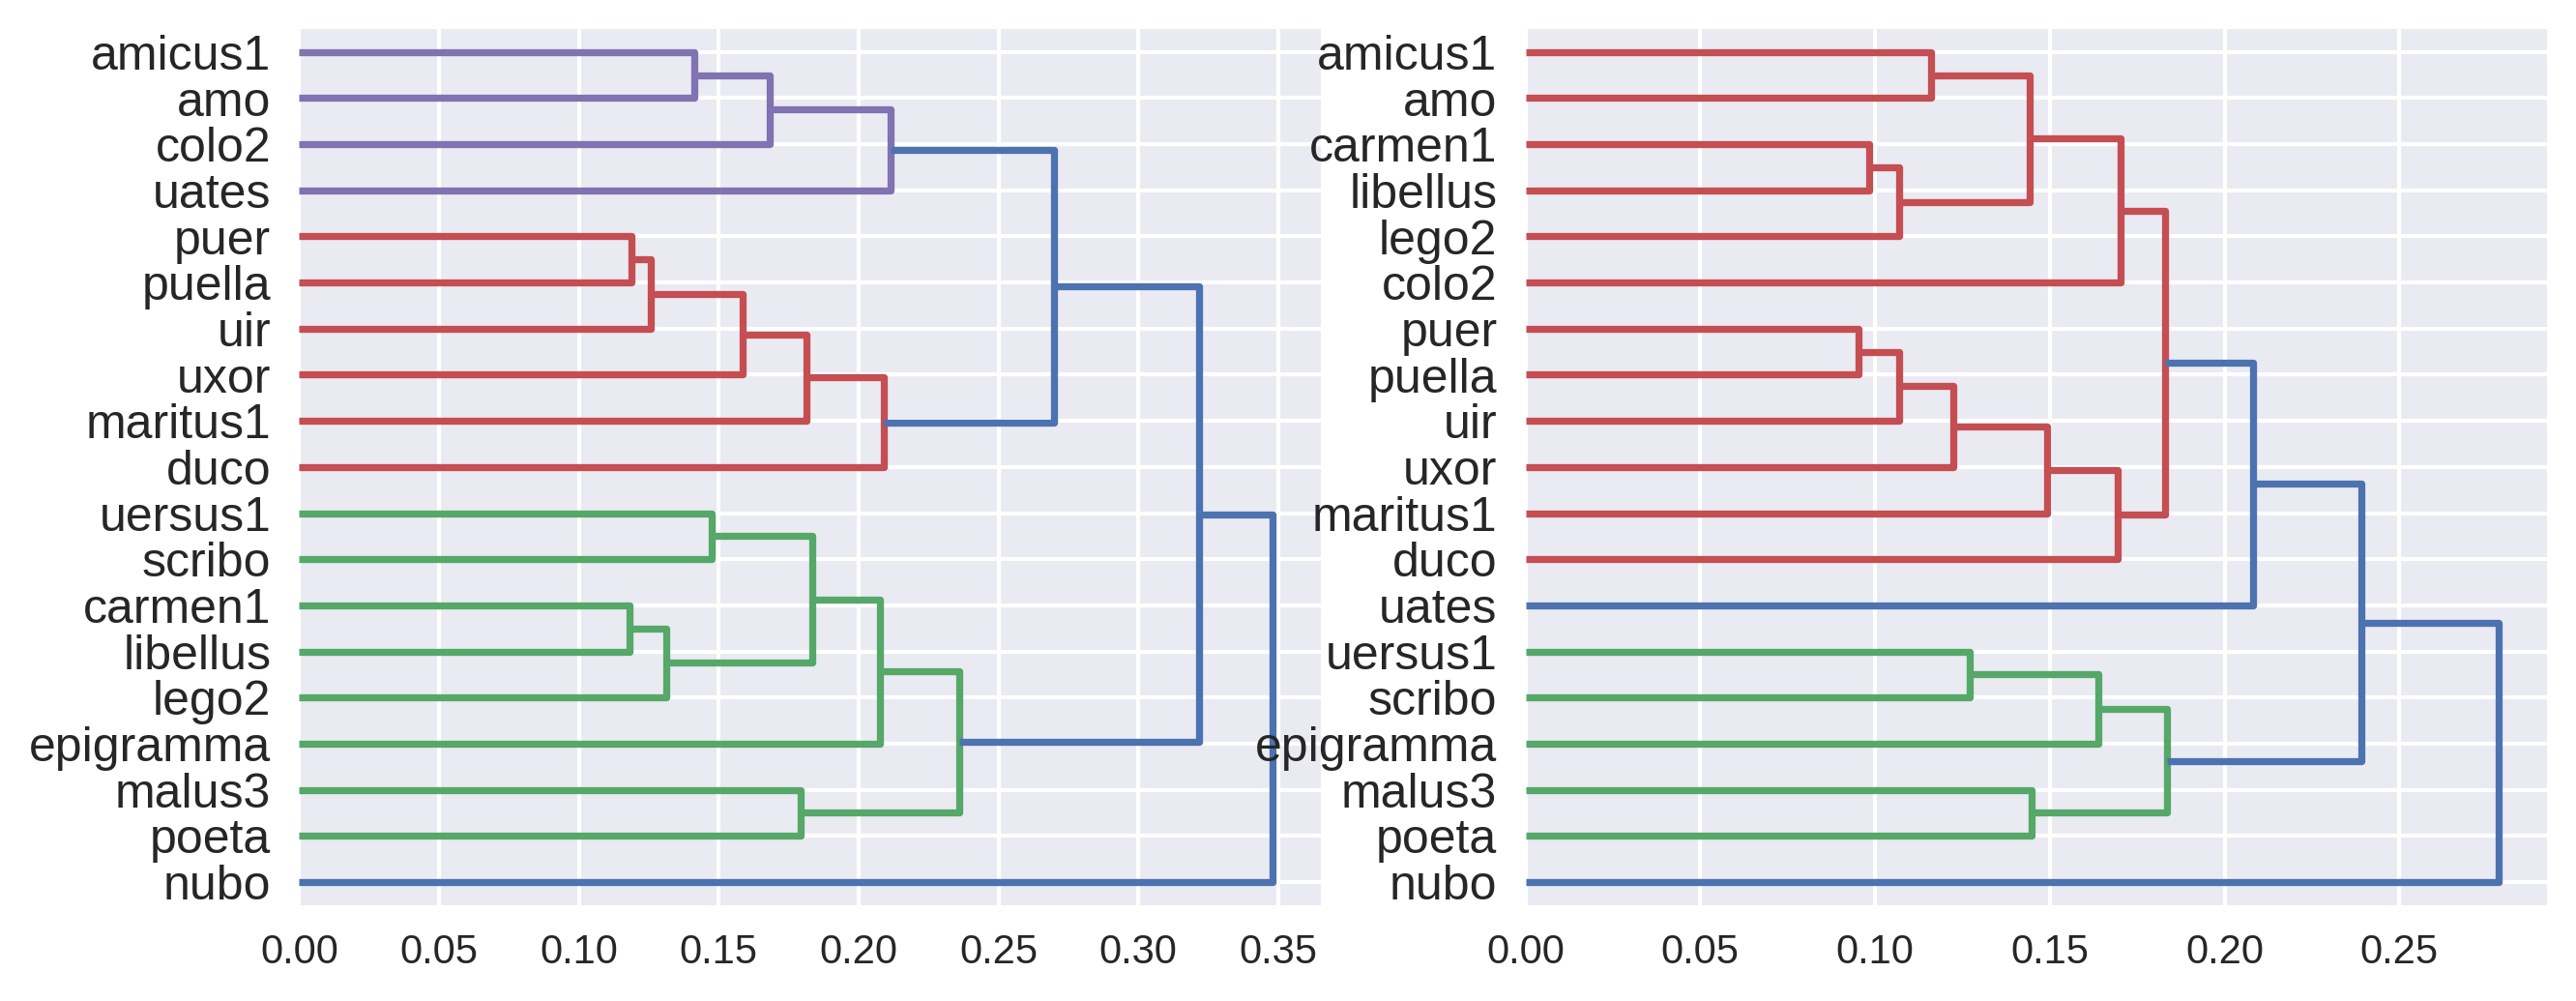

In [210]:
words = [
    "puella", "amo", "amicus1", "uir", "uxor",
    "libellus", "carmen1", "scribo", "lego2", "poeta",
    #"mentula", "cunnus",# "culus", 
    #"paedico2", "futuo", "irrumo", "fello", "fellator"
]
lexical_field = generate_adversarial(
    texts=TEXTS,
    lemma=words,
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=IGNORE_FEATURE_POS,
    pos_for_classes=POS_FOR_CLASSES,
    ignore_words=IGNORE_WORDS+("ago", ),
    drop_non_redondant_indexes=True,
    scorer_floor=lambda x: x.quantile(0.90)
)
if PLOT:
    plotly_fig, pyplot_fig = plot(
        lexical_field.coocs,
        lexical_field.decomps,
        plotly=PLOTLY, pyplot=PYPLOT
    )
    if pyplot_fig is not None:
        pyplot_fig.show()
    if plotly_fig is not None:
        plotly_fig.show()
    #fig.write_html("importance-segmentation.html")
    #print(f"file://{os.getcwd()}/importance-segmentation.html")

nb_clusters = 7
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)#, sharex=True)
*_, clean_model = get_tree(lexical_field.coocs.clean, ax=ax1, nb_clusters=nb_clusters, use_scores=False)
*_, dirty_model = get_tree(lexical_field.coocs.dirty, ax=ax2, nb_clusters=nb_clusters, use_scores=False, 
         limit_to=lexical_field.coocs.clean.df_coocs.index)
fig.show()
print(lexical_field.dropped)
#print(lexical_field.coocs.clean.coocs_major)
#print(lexical_field.coocs.dirty.coocs_major)

common_clusters = 0

clean_clusters = [
    sorted(clean_model[(clean_model.cluster == i)].index.to_list())
    for i in range(nb_clusters)
]
dirty_clusters = [
    sorted(dirty_model[(dirty_model.cluster == i)].index.to_list())
    for i in range(nb_clusters)
]
for clean_cluster_i, dirty_cluster_i in zip(
    sorted(clean_clusters, key=lambda x: str(x)),
    sorted(dirty_clusters, key=lambda x: str(x))
): # nb_clusters:
    common_clusters += int(clean_cluster_i == dirty_cluster_i)
    
print(f"{common_clusters} common clusters")

### Sexuality

Applying function


Applying function


(<AxesSubplot:>, AgglomerativeClustering(compute_distances=True, n_clusters=3))

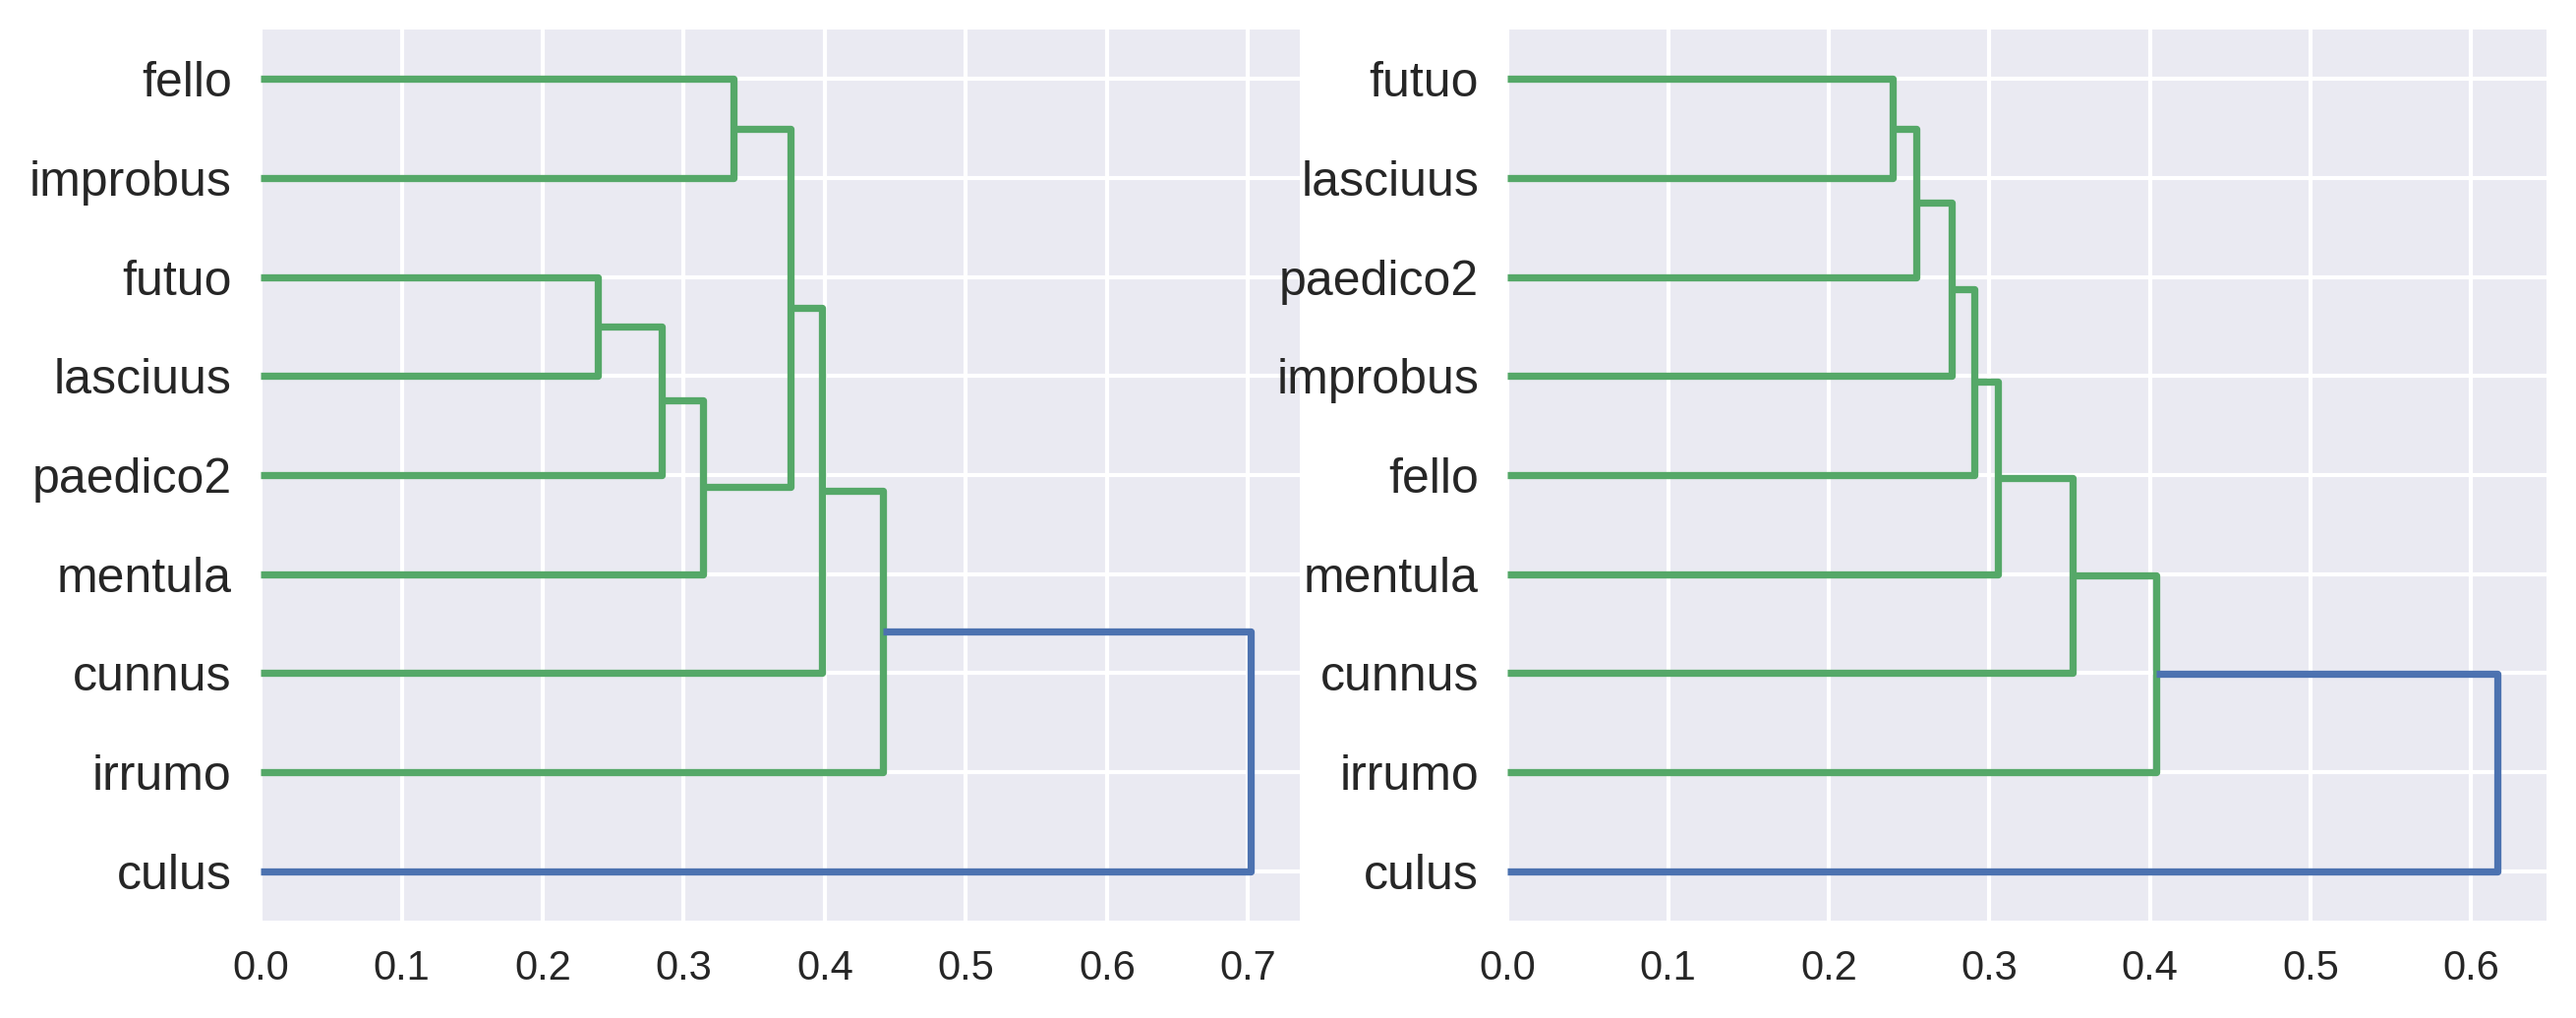

In [120]:
sexuality = generate_adversarial(
    texts=TEXTS,
    lemma=WORDS,
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=IGNORE_FEATURE_POS,
    pos_for_classes=POS_FOR_CLASSES,
    ignore_words=IGNORE_WORDS,
    drop_non_redondant_indexes=True,
    scorer_floor=lambda x: x.quantile(0.50)
)

if PLOT:
    plotly_fig, pyplot_fig = plot(
        sexuality.coocs,
        sexuality.decomps,
        plotly=PLOTLY, pyplot=PYPLOT
    )
    if pyplot_fig is not None:
        pyplot_fig.show()
    if plotly_fig is not None:
        plotly_fig.show()
    #fig.write_html("importance-segmentation.html")
    #print(f"file://{os.getcwd()}/importance-segmentation.html")
    
#AllAnalysis.append(generate_compilation(Clean, Dirty, "Mentula et al."))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
get_tree(sexuality.coocs.clean, ax=ax1, nb_clusters=3, use_scores=False)
get_tree(sexuality.coocs.dirty, ax=ax2, nb_clusters=3, use_scores=False)

### Books

In [ ]:
words = ["carmen1", "lego2", "scribo", "libellus", "poeta", "liber1"]
carmen = generate_adversarial(
    texts=TEXTS,
    lemma=words,
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=IGNORE_FEATURE_POS,
    pos_for_classes=POS_FOR_CLASSES,
    drop_non_redondant_indexes=True,
    scorer_floor=lambda x: x.median()
)

if PLOT:
    plotly_fig, pyplot_fig = plot(carmen.coocs, carmen.decomps, plotly=PLOTLY, pyplot=PYPLOT)
    if pyplot_fig is not None:
        pyplot_fig.show()
    if plotly_fig is not None:
        plotly_fig.show()
    #fig.write_html("importance-segmentation.html")
    #print(f"file://{os.getcwd()}/importance-segmentation.html")

get_tree(sexuality.coocs.clean)
get_tree(sexuality.coocs.dirty)

### Puer et Puella

In [ ]:
puer = generate_adversarial(
    texts=TEXTS,
    lemma=["puer", "puella", "uir", "dominus", "pater", "mater", "uxor"],
    window=GLOBAL_WINDOW,
    normalization=NORMALIZATION,
    floor=MIN_FREQ,
    cooc_floor=COOC_MIN_FREQ,
    ignore_pos=["PUNC", "OUT"],
    filter_pos=IGNORE_FEATURE_POS,
    pos_for_classes=POS_FOR_CLASSES,
    drop_non_redondant_indexes=True,
    scorer_floor=0.05
)

if PLOT:
    plotly_fig, pyplot_fig = plot(puer.coocs, puer.decomps, plotly=PLOTLY, pyplot=PYPLOT)
    if pyplot_fig is not None:
        pyplot_fig.show()
    if plotly_fig is not None:
        plotly_fig.show()
    #fig.write_html("importance-segmentation.html")
    #print(f"file://{os.getcwd()}/importance-segmentation.html")
    
#AllAnalysis.append(generate_compilation(Clean, Dirty, "Puer et al."))

## Analysis of Analysis

### Ideas of groups

| X       | Y                               |
| ------- | ------------------------------- |
| Group 1 | puella, amo, amicus1, uir       |
| Group 2 | libellus, carmen1, scribo, lego |

### Run analysis


In [ ]:
AllAnalysis = []

WordSets = [
    ("Puer et al.", ["puer", "puella", "uir", "dominus", "pater", "mater", "uxor"]),
    ("Carmen et al.", ["carmen1", "lego2", "scribo", "libellus", "poeta", "liber1"]),
    ("Mentula et al.", WORDS)
]

windows = [5, 10, 15, 20]
cooc_floors = [1, 5, 10, 20]

for window in windows:
    for cooc_floor in cooc_floors:
        for title, wordset in WordSets:
            try:
                Clean, Dirty, GenFreq = generate_adversarial(
                    texts=TEXTS,
                    lemma=wordset,
                    window=window,
                    normalization=NORMALIZATION,
                    floor=MIN_FREQ,
                    cooc_floor=cooc_floor,
                    ignore_pos=["PUNC", "OUT"],
                    filter_pos=IGNORE_FEATURE_POS
                )
                AllAnalysis.append(generate_compilation(Clean, Dirty, title, window, cooc_floor))
            except Exception as E:
                logging.error(f"Error on {title},{cooc_floor},{window}")
                logging.error(str(E))

In [ ]:
evolution = DataFrame(AllAnalysis)
show = []
for category in [col.split("-")[1] for col in evolution.columns if "-" in col]: 
    if f"ratio-{category}" in evolution.columns:
        continue
    evolution[f"ratio-{category}"] = evolution[f"dirty-{category}"] / evolution[f"clean-{category}"]
    show.append(f"ratio-{category}")
    
SHOW_ALL = True
if SHOW_ALL:
    display(HTML(evolution.to_html()))
else:
    display(HTML(evolution[["mots", *show]].to_html()))
    
#print(evolution.to_markdown(floatfmt="0.2f", index=False))

In [ ]:
evolution.plot.box(by="window")

## Analysis of analysis human notes:

- Any query gets substantially more features based on segment/non-segment
- Plus la fréquence minimale de cooccurence baisse pour les secondes zones
    - Plus il est probable que l'axe 1 prenne en pourcentage en segmenté
    - Moins il est probable que l'axe 1 non-segmenté fasse sens (Variation plus forte)

## Playground

In [ ]:
def compute_scores2(df):
    #i = df.index.to_list()
    #j = df.columns.to_list()
    
    Oij = np.array(df)
    Ri = np.array(df.sum(axis=1)) # Classes (Pivots)
    Cj = np.array(df.sum(axis=0)) # Feature (Coocs)
    
    return {
        "dice":  2 * Oij / np.add.outer(Ri, Cj), # 2*O_11 / (O_11 + O_12 + O_11 + O_21)
        "jaccard": Oij / (np.add.outer(Ri, Cj) - Oij) # O11 / (O_11 + O_12 + O_11 + O_21) - O11
    }

scores = compute_scores(analysis.clean.df)
df = DataFrame(scores["dice"], index=analysis.clean.df.index, columns=analysis.clean.df.columns)
drops = [
    col
    for col, val in df.max().iteritems()
    if val <= 0.01 or val == "NaN"
]
print([
    col
    for col, val in df.max().iteritems()
    if val >= 0.02 or val == "NaN"
])
print(len(df.columns), len(drops))
#display(HTML(DataFrame(scores["dice"], index=Clean.df.index, columns=Clean.df.columns).to_html()))